In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle

df = pd.read_csv('../input/data/Data_Entry_2017.csv')

diseases = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
#Number diseases
for disease in diseases :
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

In [2]:
import os
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','data','images*','images','*.png'))}
print('Images found:', len(all_image_paths))


df['Path'] = df['Image Index'].map(all_image_paths.get)

Images found: 112120


In [3]:
labels = df[diseases].to_numpy()
files_list = df['Path'].tolist()

In [4]:
df['Path'] = df['Image Index'].map(all_image_paths.get)
files_list = df['Path'].tolist()

# #test to perfect
# labelB = df['Emphysema'].tolist()

labelB = (df[diseases].sum(axis=1)>0).tolist()
labelB = np.array(labelB, dtype=int)

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, shape):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=shape)
    # converting PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)/255
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_labels = labelB[:89600][:, np.newaxis]
valid_labels = labelB[89600:100800][:, np.newaxis]
test_labels = labelB[100800:][:, np.newaxis]

img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:89600], shape = img_shape)
valid_tensors = paths_to_tensor(files_list[89600:100800], shape = img_shape)
test_tensors = paths_to_tensor(files_list[100800:], shape = img_shape)

100%|██████████| 11320/11320 [04:24<00:00, 42.85it/s]


In [6]:
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras import regularizers, applications, optimizers, initializers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [7]:
base_model = tf.keras.applications.densenet.DenseNet201(
    weights='imagenet', 
    include_top=False, 
    input_shape=train_tensors.shape[1:]
)

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(50, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.summary()

2022-11-22 19:10:09.695963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 19:10:09.813926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 19:10:09.814728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 19:10:09.815995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_____________________________

In [8]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score

In [9]:
import keras.backend as K
import tensorflow as tf

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
        precision_threshold(threshold = 0.5), 
        recall_threshold(threshold = 0.5), 
        fbeta_score_threshold(beta=0.5, threshold = 0.5)
    ]
)

In [10]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import numpy as np

epochs = 20
batch_size = 32

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')
log = CSVLogger('saved_models/log_pretrained_CNN.csv')
checkpointer = ModelCheckpoint(filepath='saved_models/pretrainedDenseNet.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

start = time.time()
train_datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False 
)

history = model.fit_generator(
    train_datagen.flow(train_tensors,train_labels, batch_size = batch_size),
    steps_per_epoch = len(train_tensors) // batch_size,
    validation_data = (valid_tensors, valid_labels),
    validation_steps = len(valid_tensors) // batch_size,
    epochs = epochs,
    callbacks=[checkpointer, log], verbose=1
#     callbacks=[checkpointer, log, earlystop], verbose=1
)

print("training time: %.2f minutes"%((time.time()-start)/60))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-22 19:10:22.456247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-22 19:10:40.817344: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2800/2800 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.6601 - precision: 0.6438 - recall: 0.5945

2022-11-22 19:16:11.304979: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 550502400 exceeds 10% of free system memory.
2022-11-22 19:16:11.599942: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 550502400 exceeds 10% of free system memory.


2800/2800 [==============================] - 362s 120ms/step - loss: 0.6308 - accuracy: 0.6601 - precision: 0.6438 - recall: 0.5945 - val_loss: 0.6304 - val_accuracy: 0.6966 - val_precision: 0.5776 - val_recall: 0.4139

Epoch 00001: val_loss improved from inf to 0.63039, saving model to saved_models/pretrainedDenseNet.best.from_scratch.hdf5
Epoch 2/20
2800/2800 [==============================] - 329s 118ms/step - loss: 0.6074 - accuracy: 0.6867 - precision: 0.6705 - recall: 0.6350 - val_loss: 0.5972 - val_accuracy: 0.6914 - val_precision: 0.5491 - val_recall: 0.6241

Epoch 00002: val_loss improved from 0.63039 to 0.59718, saving model to saved_models/pretrainedDenseNet.best.from_scratch.hdf5
Epoch 3/20
2800/2800 [==============================] - 333s 119ms/step - loss: 0.6005 - accuracy: 0.6920 - precision: 0.6776 - recall: 0.6385 - val_loss: 0.6128 - val_accuracy: 0.6829 - val_precision: 0.5561 - val_recall: 0.5682

Epoch 00003: val_loss did not improve from 0.59718
Epoch 4/20
2800/2

In [11]:
model.save('dense-adam.h5')
model.save_weights('dense-adam-weights.h5')

In [12]:
prediction = model.predict(test_tensors)

2022-11-22 21:02:03.163482: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.
2022-11-22 21:02:03.456835: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.


In [22]:
threshold = 0.5
beta = 0.5

pre = K.eval(precision_threshold(threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction)))
rec = K.eval(recall_threshold(threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction)))
#fsc = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value=test_labels),
                                   #K.variable(value=prediction)))

print ("Precision: %f %%\nRecall: %f "% (pre, rec))

Precision: 0.655261 %
Recall: 0.739711 


In [14]:
K.eval(binary_accuracy(K.variable(value=test_labels),
                       K.variable(value=prediction)))

0.6821555

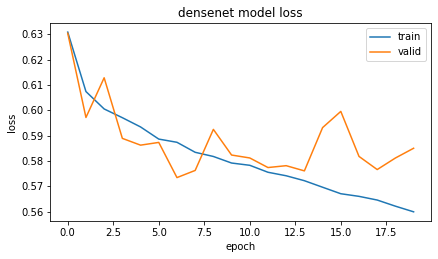

In [15]:
import matplotlib.pyplot as plt  

plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('densenet model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

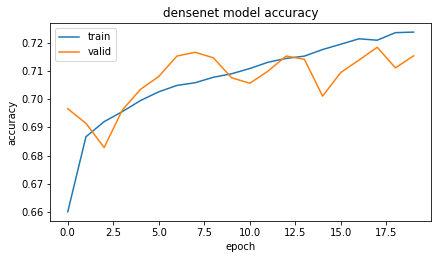

In [16]:
plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('densenet model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

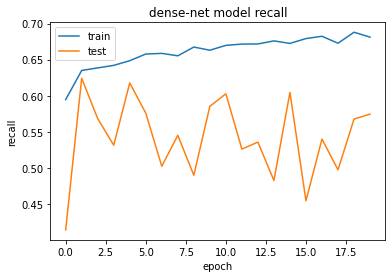

In [17]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('dense-net model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

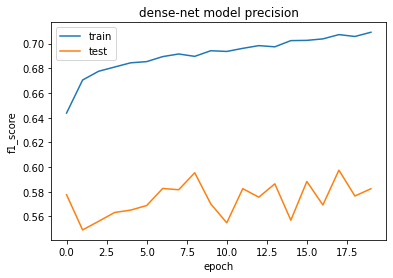

In [18]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('dense-net model precision')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()